# HR Analytics Case Study Notebook

En aquest notebook s'ha intentat donar solució a un problema d'un departament de recursos humans d'una empresa on, aproximadament, un 15 % dels treballadors cada any, deixen l'empresa (ja sigui per acomiadament o per compte propi, concepte al qual li diuen *attrition*).

L'objectiu doncs és poder predir aquests perfils amb l'aplicació de l'aprenentatge computacional per tal de que el departament pugui tomar accions en base a les dades recopilades durant un any.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100


# Dades de les enquestes i dades generals dels treballadors
employee_data = pd.read_csv("./dataset/employee_survey_data.csv")
manager_data = pd.read_csv("./dataset/manager_survey_data.csv")
general_data = pd.read_csv("./dataset/general_data.csv")

# Temps d'entrada i sortida del treball de tot l'any de cada treballador
in_time = pd.read_csv("./dataset/in_time.csv")
out_time = pd.read_csv("./dataset/out_time.csv")

# 1. Preprocessat

In [2]:
# Calcular hora d'entrada i sortida mitjans per cada treballador
in_time = in_time.drop(in_time.columns[0], axis=1)
in_time = in_time.astype("datetime64[ns]")
in_time = in_time.applymap(lambda x: x.hour + x.minute/60 if not pd.isna(x.hour) else np.nan)

out_time = out_time.drop(out_time.columns[0], axis=1)
out_time = out_time.astype("datetime64[ns]")
out_time = out_time.applymap(lambda x: float(f"{x.hour}.{x.minute}") if not pd.isna(x.hour) else np.nan)

general_data["MeanInTime"] = in_time.mean(axis=1)
general_data["MeanOutTime"] = out_time.mean(axis=1)

In [3]:
# Agrupar dades
employee_data = employee_data.drop("EmployeeID", axis=1)
manager_data = manager_data.drop("EmployeeID", axis=1)
general_data = general_data.drop("EmployeeID", axis=1)
data = pd.concat([general_data, employee_data, manager_data], axis=1)
data

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MeanInTime,MeanOutTime,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
0,51,No,Travel_Rarely,Sales,6,2,Life Sciences,1,Female,1,...,1,0,0,9.993032,17.258621,3.0,4.0,2.0,3,3
1,31,Yes,Travel_Frequently,Research & Development,10,1,Life Sciences,1,Female,1,...,5,1,4,9.980720,17.601229,3.0,2.0,4.0,2,4
2,32,No,Travel_Frequently,Research & Development,17,4,Other,1,Male,4,...,5,0,3,10.016598,16.895289,2.0,2.0,1.0,3,3
3,38,No,Non-Travel,Research & Development,2,5,Life Sciences,1,Male,3,...,8,7,5,9.973830,17.046383,4.0,4.0,3.0,2,3
4,32,No,Travel_Rarely,Research & Development,10,1,Medical,1,Male,1,...,6,0,4,9.990068,17.881796,4.0,1.0,3.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4405,42,No,Travel_Rarely,Research & Development,5,4,Medical,1,Female,1,...,3,0,2,10.011317,18.396955,4.0,1.0,3.0,3,3
4406,29,No,Travel_Rarely,Research & Development,2,4,Medical,1,Male,1,...,3,0,2,9.996196,15.975436,4.0,4.0,3.0,2,3
4407,25,No,Travel_Rarely,Research & Development,25,2,Life Sciences,1,Male,2,...,4,1,2,9.971501,17.548528,1.0,3.0,3.0,3,4
4408,42,No,Travel_Rarely,Sales,18,2,Medical,1,Male,1,...,9,7,8,10.010650,19.355021,4.0,1.0,3.0,2,3


In [4]:
# Informació dels tipus de columnes i quantitat de files no-nules per cadascuna
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 30 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   object 
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   int64  
 6   EducationField           4410 non-null   object 
 7   EmployeeCount            4410 non-null   int64  
 8   Gender                   4410 non-null   object 
 9   JobLevel                 4410 non-null   int64  
 10  JobRole                  4410 non-null   object 
 11  MaritalStatus            4410 non-null   object 
 12  MonthlyIncome            4410 non-null   int64  
 13  NumCompaniesWorked       4391 non-null   float64
 14  Over18                  

In [5]:
from sklearn.preprocessing import LabelEncoder

# Codificar dades categoriques (ignorarem els valors nuls al ser pocs)
labeled_cols = data.columns[data.dtypes == "object"]
col_encoders = {col: LabelEncoder() for col in labeled_cols}

data_encoded = data.copy()

for col, le in col_encoders.items():
    data_encoded[col] = le.fit_transform(data[col])

data_encoded.describe()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,Gender,JobLevel,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MeanInTime,MeanOutTime,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
count,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4410.0,4410.000000,4410.000000,...,4410.000000,4410.000000,4410.000000,4410.000000,4410.000000,4385.000000,4390.000000,4372.000000,4410.000000,4410.000000
mean,36.923810,0.161224,1.607483,1.260544,9.192517,2.912925,2.247619,1.0,0.600000,2.063946,...,7.008163,2.187755,4.123129,9.991773,17.563634,2.723603,2.728246,2.761436,2.729932,3.153741
std,9.133301,0.367780,0.665304,0.527673,8.105026,1.023933,1.331067,0.0,0.489954,1.106689,...,6.125135,3.221699,3.567327,0.018147,1.339622,1.092756,1.101253,0.706245,0.711400,0.360742
min,18.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.0,0.000000,1.000000,...,0.000000,0.000000,0.000000,9.929079,15.761404,1.000000,1.000000,1.000000,1.000000,3.000000
25%,30.000000,0.000000,1.000000,1.000000,2.000000,2.000000,1.000000,1.0,0.000000,1.000000,...,3.000000,0.000000,2.000000,9.979616,16.515815,2.000000,2.000000,2.000000,2.000000,3.000000
50%,36.000000,0.000000,2.000000,1.000000,7.000000,3.000000,2.000000,1.0,1.000000,2.000000,...,5.000000,1.000000,3.000000,9.991957,17.278963,3.000000,3.000000,3.000000,3.000000,3.000000
75%,43.000000,0.000000,2.000000,2.000000,14.000000,4.000000,3.000000,1.0,1.000000,3.000000,...,9.000000,3.000000,7.000000,10.003581,18.210203,4.000000,4.000000,3.000000,3.000000,3.000000
max,60.000000,1.000000,2.000000,2.000000,29.000000,5.000000,5.000000,1.0,1.000000,5.000000,...,40.000000,15.000000,17.000000,10.069684,20.958826,4.000000,4.000000,4.000000,4.000000,4.000000


In [6]:
# Borrem columnes sense variabilitat (std=0) que no ens interesen
not_interesting = data.columns[data_encoded.std() == 0]
data_encoded.drop(not_interesting, inplace=True, axis=1)
data.drop(not_interesting, inplace=True, axis=1)
not_interesting

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')

In [7]:
from sklearn.preprocessing import StandardScaler

# Treiem valors nuls i normalitzem (amb estandarització z-score)
sc = StandardScaler()
data_encoded_nona = data_encoded.dropna()
X = data_encoded_nona.drop("Attrition", axis=1)
Xn = pd.DataFrame(sc.fit_transform(X), columns=X.columns)
y = data_encoded_nona["Attrition"]

# 2. EDA

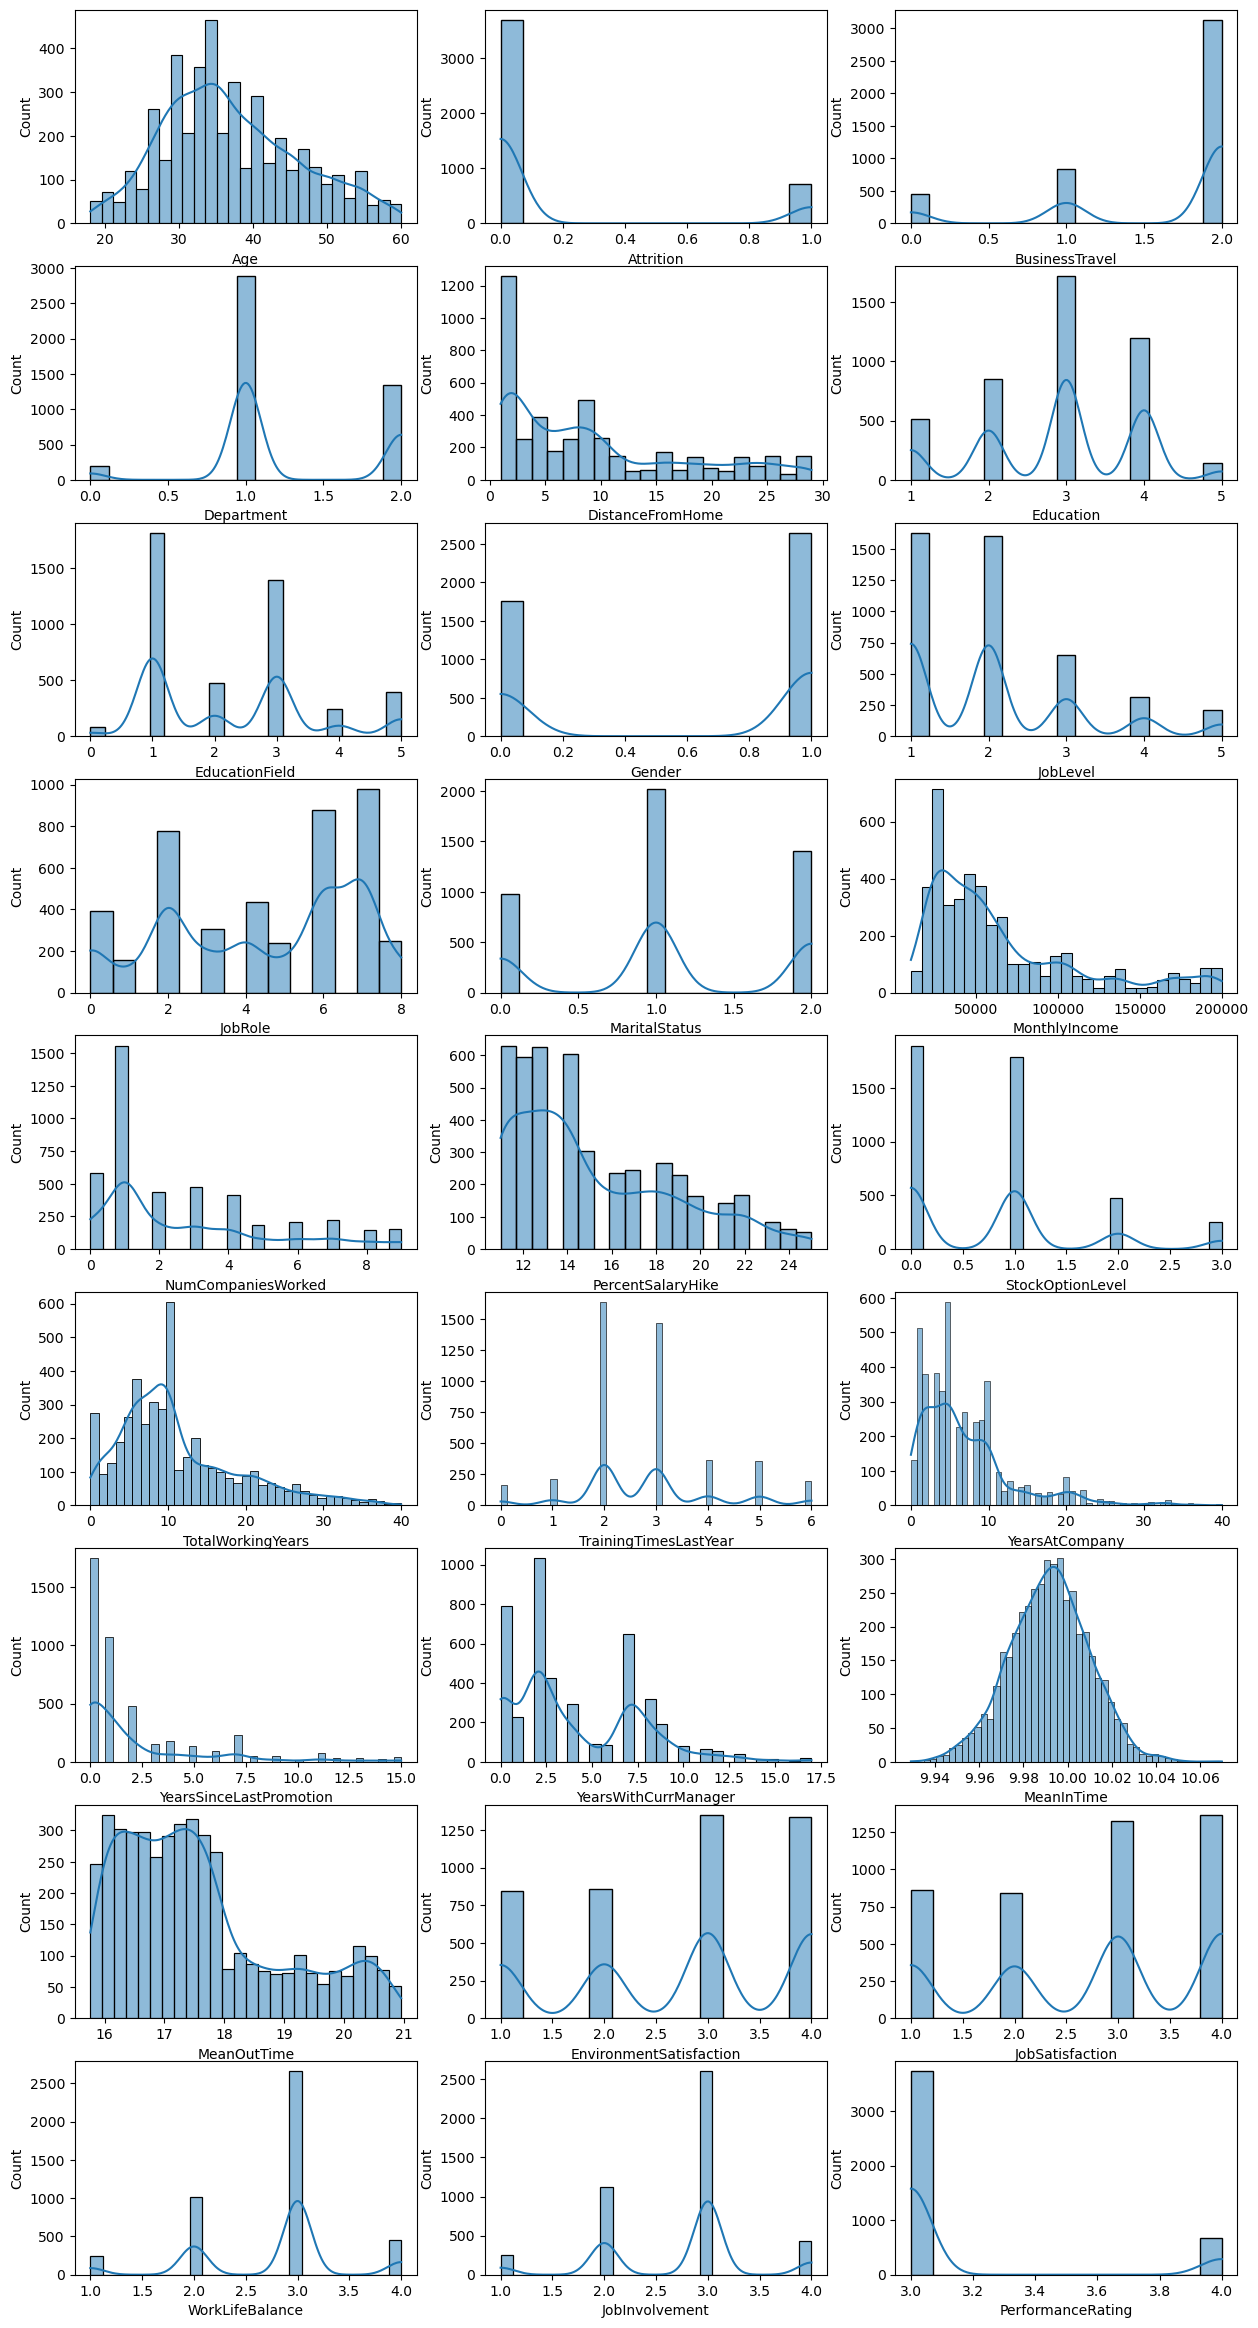

In [8]:
# Histogrames de les caracteristiques
def plot_hists(df, cols=None, hue=None, size=(15, 30), colwidth=3):
    fig, axs = plt.subplots(int(np.ceil(len(cols)/colwidth)), colwidth, figsize=size)
    for i, c in enumerate(cols):
        plt.subplot(int(np.ceil(len(cols)/colwidth)), colwidth, i+1)
        sns.histplot(df, x=c, kde=True, hue=hue, multiple="stack")

plot_hists(data_encoded, cols=data_encoded.columns)
plt.show()

,Attrition
No,0.838776
Yes,0.161224


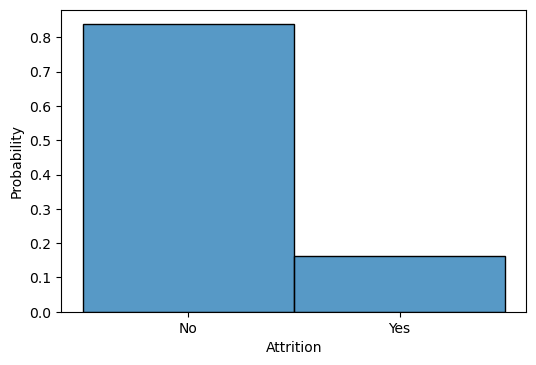

In [9]:
# Balanceig de les classes
sns.histplot(data["Attrition"], stat="probability")
data["Attrition"].value_counts(normalize=True).to_frame()

Com veiem tenim una distribució de les classes bastant desbalanceigada, per tant, caldrà tenir en compte quina mètrica utilitzem per avaluar els models, ja que sabem que per exemple l'accuracy pot donar una sensació falsa de bon rendiment del model en aquests casos de desbalanceig (i.e. un model que sempre predigui la classe majoritària tindrà més accuracy com més desbalanceig hi hagui, en aquest cas podria rondar el 80%).

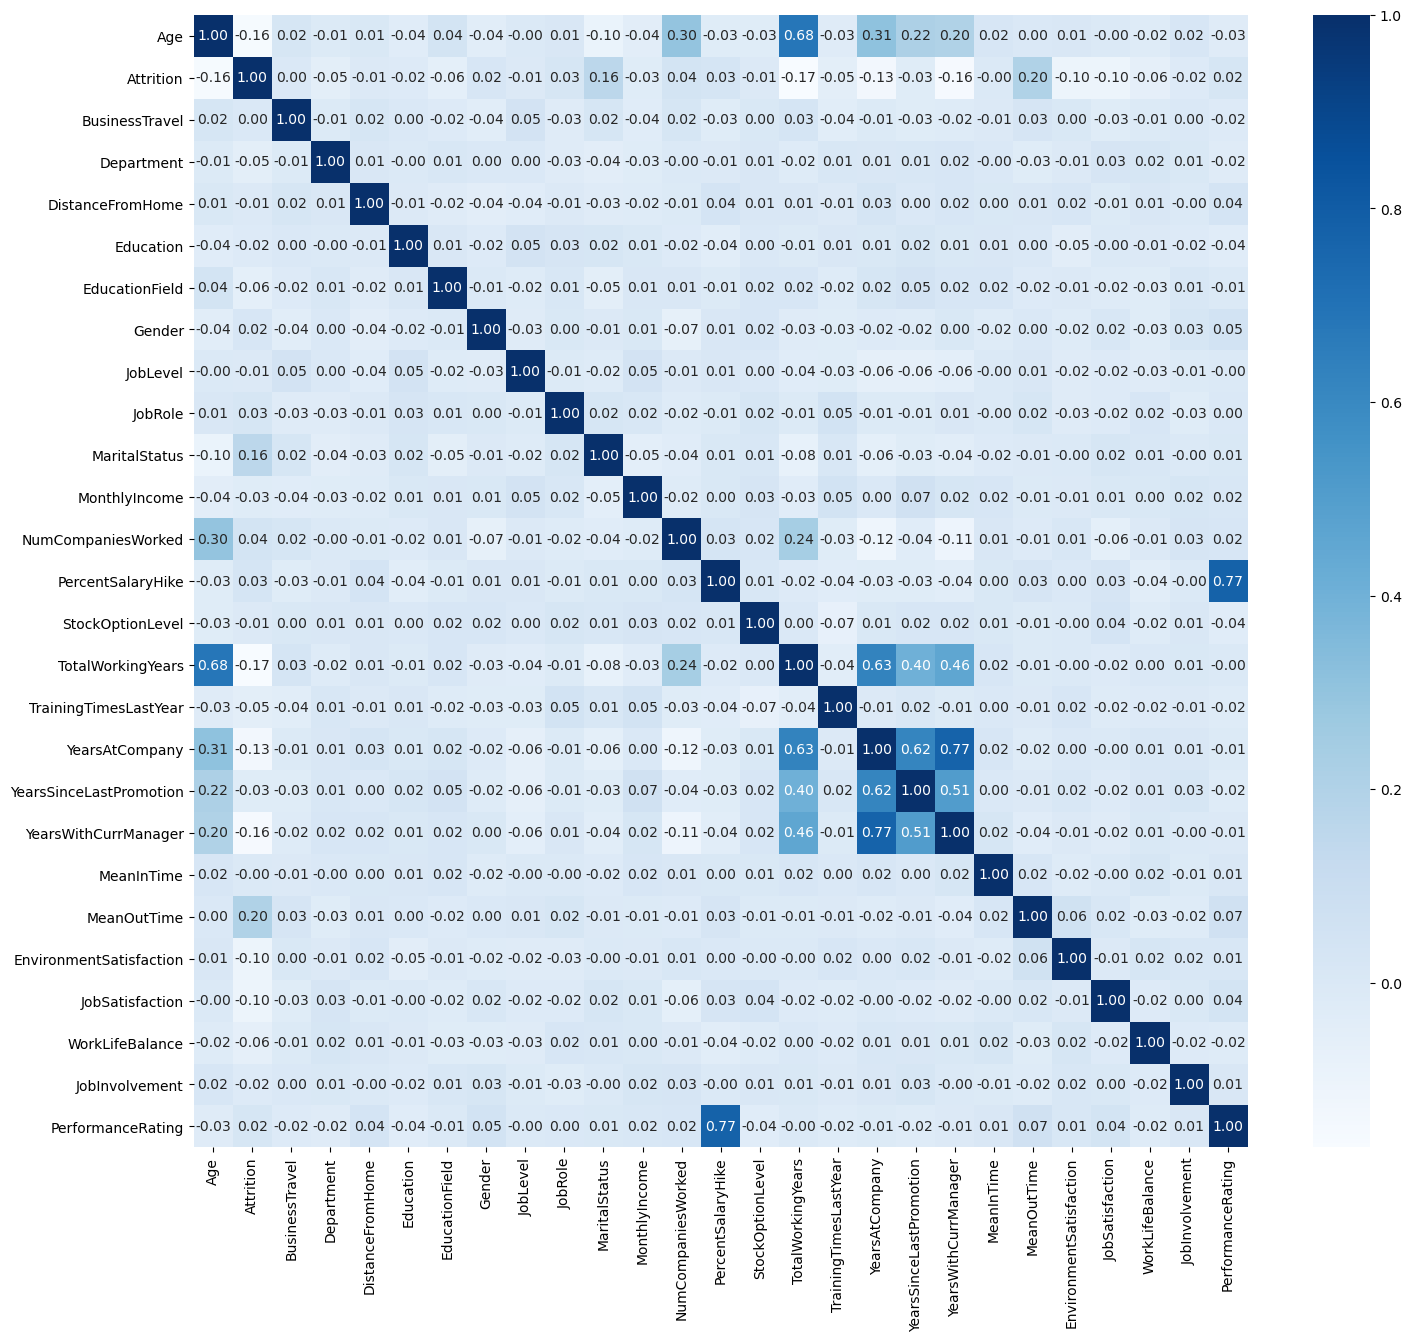

In [10]:
# Heatmap de correlació
plt.figure(figsize=(17,15))
corr = data_encoded.corr()
sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.show()

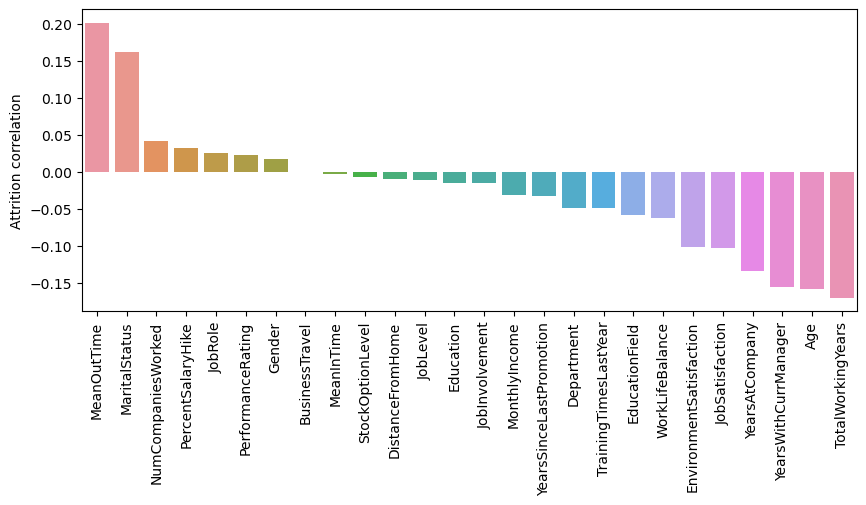

In [11]:
# Barplot de correlació de l'Attrition amb la resta
plt.figure(figsize=(10,4))
top_corr = corr["Attrition"].drop("Attrition").sort_values(ascending=False)
sns.barplot(x=top_corr.index, y=top_corr)
plt.ylabel("Attrition correlation")
plt.xticks(rotation=90)
plt.show()

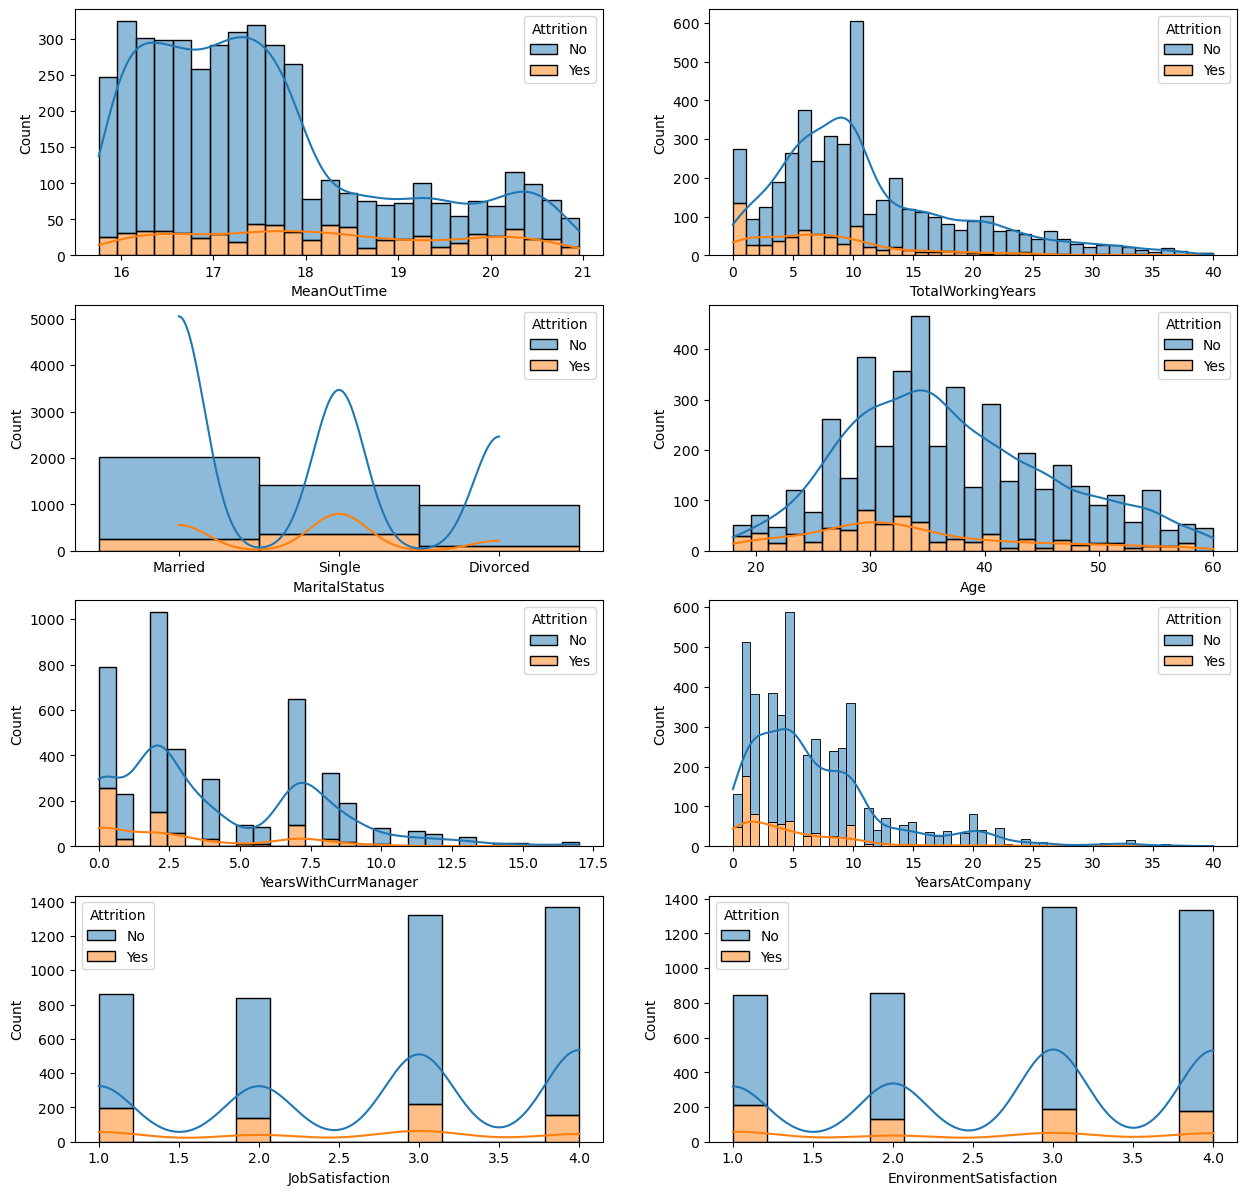

In [12]:
top8_abs_corr_cols = np.abs(top_corr).sort_values(ascending=False)[:8].index
plot_hists(data, cols=top8_abs_corr_cols, hue="Attrition", size=(15,15), colwidth=2)
plt.show()

Per les dades veiem que el perfil tendent (encara que de forma lleu) a anar-se'n de l'empresa és gent que surt tard del treball, està soltera, és jove (<40 anys), no té un manager estable, i no té molta experiència acumulada ni en la seva vida laboral ni en l'empresa. Addicionalment, aquestes persones també notifiquen dades més negatives quant a la satisfacció del treball i de l'entorn.


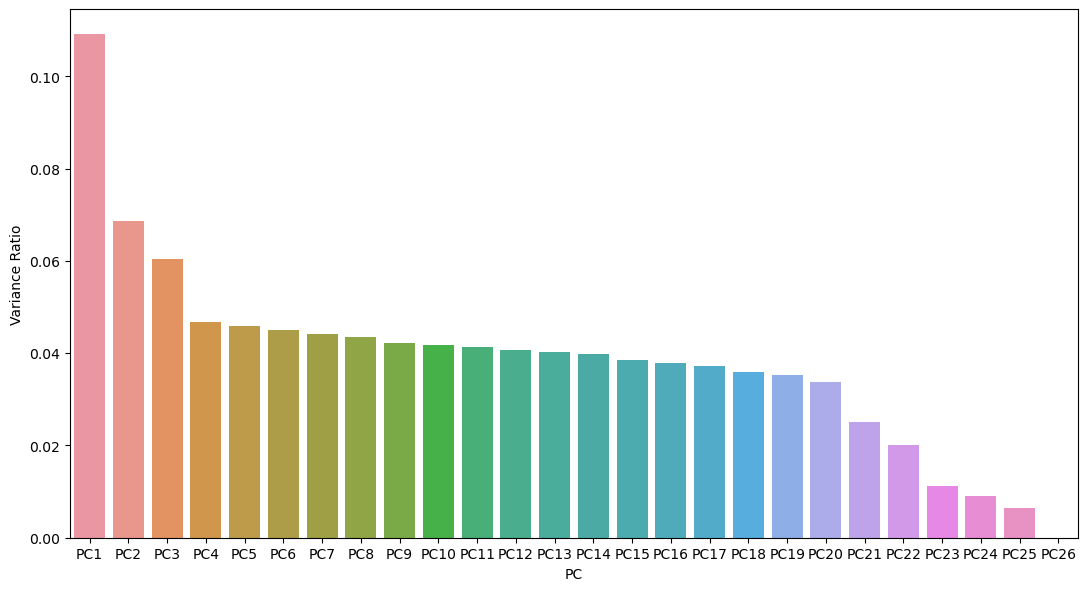

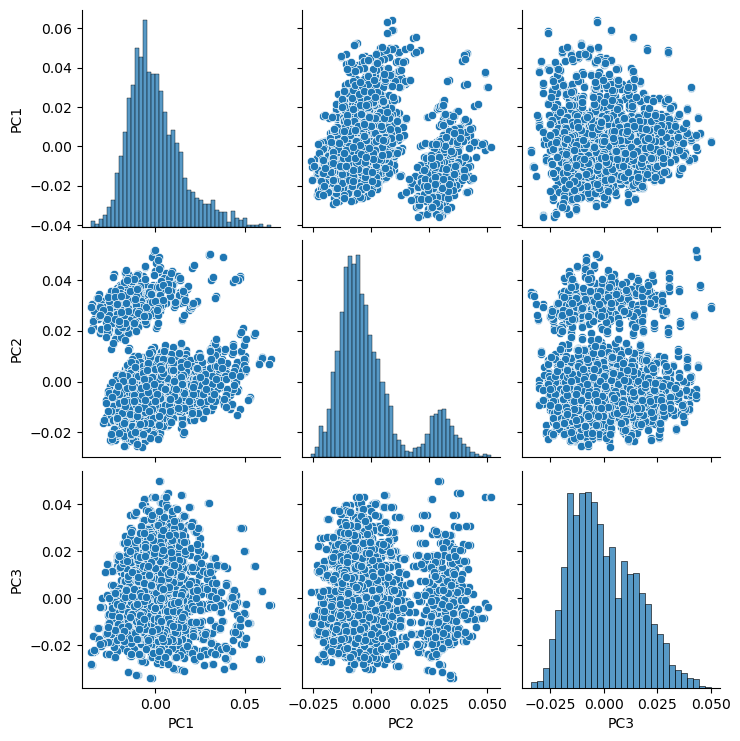

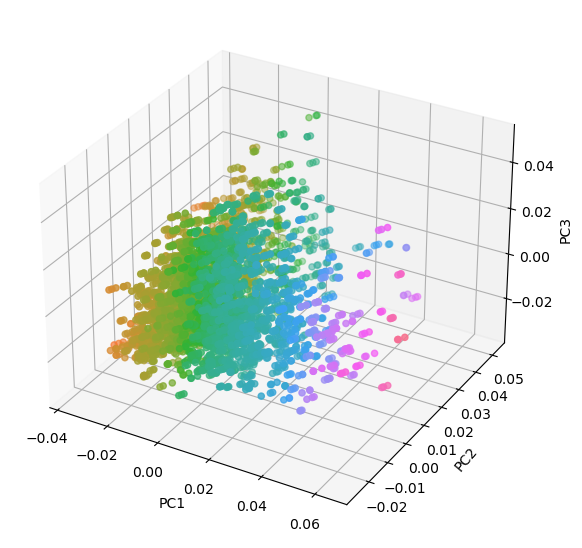

In [13]:
from sklearn.decomposition import PCA
from matplotlib.colors import ListedColormap

pca = PCA().fit(Xn.to_numpy().T)
pca_df = pd.DataFrame({f"PC{i+1}" : pca.components_[i] for i in range(len(pca.components_))})

pca_vr = pd.DataFrame({"PC" : pca_df.columns, "Variance Ratio": pca.explained_variance_ratio_})

# Barplot amb el ratio d'implicació a la variancia dels PC
plt.figure(figsize=(13,7))
sns.barplot(data=pca_vr, x="PC", y="Variance Ratio")

# Scatterplots 2D de PCA1, PCA2 i PCA3
v = ["PC1", "PC2", "PC3"]
sns.pairplot(data=pca_df, vars=v)
plt.show()

# Scatterplot 3D de PCA1, PCA2 i PCA3
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(projection="3d")
cmap = ListedColormap(sns.color_palette("husl", 256).as_hex())
ax.scatter(pca_df["PC1"], pca_df["PC2"], pca_df["PC3"], c=pca_df["PC1"], cmap=cmap)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2", rotation=50)
ax.set_zlabel("PC3", rotation=90)
plt.show()

L'analisis PCA dona uns components amb poc ratio d'implicació a la variança (menor al 10%), i per tant no s'utilitza.

# 3. Evaluació i selecció de models

In [14]:
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

def plot_cm(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, cmap="Blues", fmt=".0f", cbar=False, annot_kws={"size": 12})
    plt.xlabel("Predicted label")
    plt.xticks(size=12, rotation=0)
    plt.ylabel("True label")
    plt.yticks(size=12, rotation=0)
    plt.show()
    

# Partir el dataset en 70 % train in 30 % test
state = 44203
X_train, X_test, y_train, y_test = train_test_split(Xn, y, test_size=.3, random_state=state)

# Generar un baseline de rendiment pels diferents models escollits amb validació creuada
# (estratificada amb k=5) amb parametres per defecte

models = [
    ("LRegression", LogisticRegression(random_state=state)),
    ("SVM", SVC(random_state=state)),
    ("RForest", RandomForestClassifier(random_state=state)),
    ("KNN", KNeighborsClassifier()),
    ("NBayes", GaussianNB())
]

scoring = ("accuracy", "precision_macro", "recall_macro", "f1_macro")
table = pd.DataFrame(columns=scoring)

for name, model in models:
    scores = cross_validate(
        model, X_train, y_train, n_jobs=-1,
        cv=StratifiedKFold(n_splits=5),
        scoring=scoring
    )
    
    table.loc[name] = [np.mean(scores[f"test_{s}"]) for s in scoring]

# Visualitzar mitjanes de la validació creuada
table

,accuracy,precision_macro,recall_macro,f1_macro
LRegression,0.859468,0.775976,0.615382,0.643382
SVM,0.896678,0.894887,0.701238,0.751892
RForest,0.964452,0.970281,0.897774,0.929210
KNN,0.852159,0.732881,0.623374,0.650054
NBayes,0.820266,0.671068,0.673735,0.672177


Com podem veure, el model basat en Random Forest presenta unes mètriques mitjanes de rendiment de la validació creuada molt bones, ja que no només adquireix un accuracy molt alt, del 96 %, sinó que també obté valors del 97 % i del 89 % en les mitjanes macro (i.e. no ponderejada, es tracten totes les classes per igual) de precisió i recall, respectivament, a més d'un 92 % en la mètrica f1, que combina aquestes dues, el que ens indica que ho està fent prou bé en la classe positiva (i.e. en predir els treballadors que marxen), que és el que és el que volem fer. Per altra banda, el SVM sembla ser el segon millor model, però encara així es queda força distant del rendiment del Random Forest, així que a partir d'ara ens centrarem només en aquest, ja que sembla prometedor.

# 4. Busqueda d'hiperparàmetres

In [15]:
from sklearn.model_selection import RandomizedSearchCV

# Buscar els millors parametres pel classificador basat en Random Forest de forma
# aleatoria amb RandomizedSearchCV i la elecció de f1 com a métrica de scoring
# per la validació creuada en la seva versió macro per comptar totes les classes
# per igual

params = {
    "n_estimators": [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    "criterion": ["gini", "entropy"],
    "bootstrap": [True, False],
    "class_weight": ["balanced", "balanced_subsamble"],
    "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "max_features": ["auto", "sqrt", "log2"],
    "min_samples_leaf": [1, 2, 4, 8, 16],
    "min_samples_split": [2, 5, 10, 20],
}

grid = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=state, n_jobs=-1),
    cv=StratifiedKFold(n_splits=5),
    n_iter=100,
    param_distributions=params,
    scoring='f1_macro',
    n_jobs=-1,
    verbose=1,
    random_state=state
)

grid.fit(X_train, y_train)
best_rf = grid.best_estimator_
print(best_rf)
print(f"Best RF macro-f1 score: {grid.best_score_:.4f}")

Fitting 5 folds for each of 100 candidates, totalling 500 fits


/usr/lib/python3.10/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.81893051 0.8326582  0.79738446 0.86198532        nan        nan
 0.83814594        nan        nan        nan        nan 0.91959574
        nan        nan        nan 0.83731311 0.93771147 0.92312373
        nan        nan 0.83927478 0.9343085         nan 0.89464797
 0.86043401        nan        nan 0.94070037 0.91607316 0.93795861
        nan        nan 0.90390913        nan 0.79236599        nan
 0.79140099 0.84098315 0.92645987 0.87804897 0.89564008 0.83639228
        nan        nan        nan        nan 0.82005199 0.83007071
 0.78682239        nan        nan 0.92761317        nan        nan
        nan        nan 0.83814594        nan 0.9365733  0.91619313
        nan        nan        nan        nan 0.89839652 0.91599156
 0.9334733         nan        nan        nan        nan        nan
        nan        nan 0.92014818        nan 0.8952983        

RandomForestClassifier(bootstrap=False, class_weight='balanced', max_depth=30,
                       max_features='log2', n_estimators=800, n_jobs=-1,
                       random_state=44203)
Best RF macro-f1 score: 0.9407


# 5. Validació final del model

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      1083
           1       0.99      0.92      0.96       207

    accuracy                           0.99      1290
   macro avg       0.99      0.96      0.97      1290
weighted avg       0.99      0.99      0.99      1290



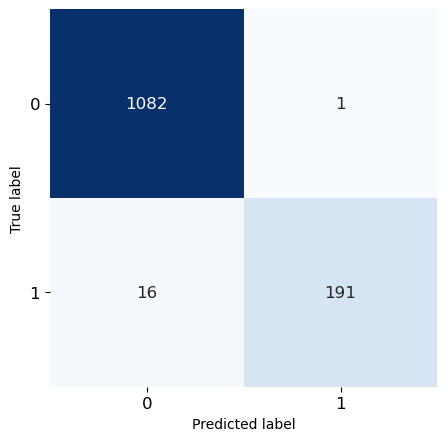

In [21]:
# Classificació amb el model final amb les dades de testeig del millor model trobat

best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
print(classification_report(y_test, y_pred))
plot_cm(y_test, y_pred)

In [22]:
# Mostrar els falsos positius que s'obtenen
print("Falsos positius: ")
FP = y_test[y_pred == 1][y_test == 0].index
data_encoded_nona.loc[FP]

Falsos positius: 


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MeanInTime,MeanOutTime,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
2286,33,0,2,1,15,4,1,0,1,7,...,0,0,0,9.99814,18.364008,4.0,3.0,3.0,2,3


In [18]:
print("Falsos negatius: ")
FN = y_test[y_pred == 0][y_test == 1].index
data_encoded_nona.loc[FN]

Falsos negatius: 


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MeanInTime,MeanOutTime,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
3248,47,1,1,1,4,3,1,1,1,5,...,5,1,3,9.991164,19.881293,2.0,3.0,3.0,3,3
2218,49,1,1,2,6,5,3,0,2,0,...,4,1,3,9.989891,16.901352,1.0,1.0,3.0,3,3
748,49,1,1,2,6,5,3,0,2,0,...,4,1,3,10.023319,16.984202,1.0,1.0,3.0,3,3
810,28,1,1,2,1,3,2,1,2,2,...,0,0,0,9.996926,17.416393,3.0,1.0,2.0,3,3
2946,28,1,2,1,11,2,3,1,2,7,...,0,0,0,9.985028,16.794025,1.0,3.0,1.0,3,4
3750,28,1,1,2,1,3,2,1,2,2,...,0,0,0,10.008806,17.478210,3.0,1.0,2.0,3,3
6,28,1,2,1,11,2,3,1,2,7,...,0,0,0,9.956250,16.754828,1.0,3.0,1.0,3,4
3688,49,1,1,2,6,5,3,0,2,0,...,4,1,3,9.998752,17.013084,1.0,1.0,3.0,3,3
1778,47,1,1,1,4,3,1,1,1,5,...,5,1,3,9.976099,19.869915,2.0,3.0,3.0,3,3
3327,29,1,2,2,3,3,2,1,3,2,...,3,0,2,9.948511,19.211447,2.0,3.0,3.0,3,3


In [19]:
print("Alguns positius vertaders:")
TP = y_test[y_pred == 1][y_test == 1].index
data_encoded_nona.loc[TP]

Alguns positius vertaders:


,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,...,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,MeanInTime,MeanOutTime,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating
1338,58,1,2,2,2,2,3,0,1,6,...,40,15,6,9.949786,17.364274,4.0,4.0,2.0,2,3
2732,48,1,2,1,2,4,5,0,1,7,...,1,0,0,10.000570,19.164274,1.0,3.0,3.0,1,3
2025,39,1,1,2,1,3,2,1,2,0,...,18,11,5,10.018122,17.090568,1.0,4.0,3.0,3,3
2048,29,1,2,1,6,3,1,1,1,7,...,11,3,10,10.024211,16.656214,4.0,1.0,1.0,1,3
4284,31,1,2,1,15,1,3,0,2,7,...,2,2,2,9.989912,18.263202,2.0,3.0,3.0,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
681,32,1,2,1,5,3,5,0,1,7,...,10,1,1,9.976050,16.340966,4.0,3.0,3.0,3,3
4120,23,1,1,1,2,4,1,0,2,4,...,1,1,0,9.973333,17.837837,4.0,1.0,2.0,3,3
1257,41,1,2,2,20,4,2,1,2,7,...,22,15,8,9.996070,15.825852,2.0,3.0,3.0,3,3
775,31,1,1,2,2,3,3,1,2,7,...,10,4,7,10.003493,16.653712,3.0,2.0,3.0,3,3


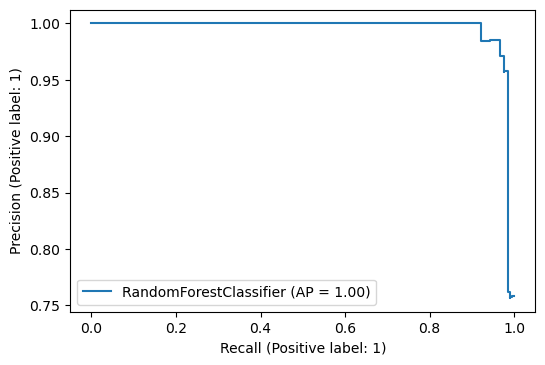

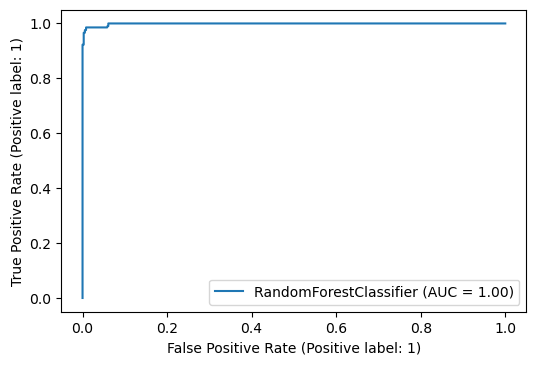

In [20]:
from sklearn.metrics import plot_precision_recall_curve, plot_roc_curve

# Corbes Precision-Recall i ROC del model final amb les dades de testeig
plot_precision_recall_curve(best_rf, X_test, y_test)
plot_roc_curve(best_rf, X_test, y_test)
plt.show()


In [28]:
pd.DataFrame(pd.Series(best_rf.feature_importances_, Xn.columns), columns=["Importance"]).sort_values("Importance", ascending=False)

,Importance
MeanOutTime,0.121525
Age,0.077520
TotalWorkingYears,0.073316
MonthlyIncome,0.066092
YearsAtCompany,0.065713
YearsWithCurrManager,0.054277
DistanceFromHome,0.050394
PercentSalaryHike,0.045652
JobRole,0.037961
JobSatisfaction,0.036424


# 6. Conclusions  i treball futur

Amb aquest estudi s'ha pogut concloure en què el model basat en Random Forest fa un molt bon treball de serie, amb paràmetres per defecte, cosa que s'ha aprofitat per realitzar un *tunning* dels hiperparàmetres amb una cerca aleatòria. Fent això s'ha acabat assolint un accuracy del 99 %, una precision del 99 %, un recall del 96 % i un f1-score del 97 % validat amb un conjunt de test del 30 % de les dades totals utilitzades, i, per tant, un conjunt del 70 % de dades d'entrenament.

Finalment, amb aquest millor model resultant de la busqueda aleatòria s'ha pogut comprovar també les importàncies de cada atribut, veient com el temps de sortida és el factor més important amb diferència, seguit de l'edat i dels anys d'experiència laboral del treballador, com ja s'havia analitzat en l'apartat d'anàlisis (EDA), encara que també hi ha d'altres que no s'havien dit a priori, com per exemple el salari del treballador.

En treballs futurs es podria obrir la porta a utilitzar nous models basats en ensembles com el Random Forest, com per exemple AdaBoost o d'altres més complexos basats en la votació, i també d'altres tipus no estudiats, com ara les xarxes neurals, encara que segurament serà difícil millorar el rendiment.